## VADER

In [31]:
text_neg = "However, it is well-known that the WSR maximization problem is NP-hard"
text_pos = "The paper provides a valuable insight into the topic."
text_neu = "MASSIVE MU-MIMO is one of the key enabling technologies for the fifth-generation and next-generation networks"
text1 = "“在Smith的研究基础上，我们进一步探讨了...（Smith, 2010）"
text2 = "本研究采用了类似于Johnson等人提出的方法...（Johnson et al., 2011）"
text3 = "Unlike recent language representation models (Peters et al., 2018a; Radford et al., 2018), BERT is designed to pretrain deep bidirectional representations from unlabeled text by jointly conditioning on both left and right context in all layers."

In [6]:
# from nltk.sentiment.vader import SentimentIntensityAnalyzer
# import nltk
# 
# # 下载VADER词典
# nltk.download('vader_lexicon')
# sia = SentimentIntensityAnalyzer()
# sentiment_scores = sia.polarity_scores(text_3)
# print(sentiment_scores)

## Flair库

In [4]:
# from flair.models import TextClassifier
# from flair.data import Sentence
# 
# classifier = TextClassifier.load('en-sentiment')
# sentence = Sentence(text_neg)
# classifier.predict(sentence)
# print(sentence.labels)

## BERT-based模型

In [9]:
TEST_DATASET_SIZE = 0.4
NUM_LABELS = 3

In [32]:
from transformers import pipeline

distilbert_model_sst2 = './model/distilbert-base-uncased-finetuned-sst-2-english'
# distilbert-base-uncased-finetuned-sst-2-english——DistilBERT
# roberta-base——RoBERTa
# # albert-base-v2——ALBERT
# sa_classifier = pipeline(task='sentiment-analysis', model='distilbert-base-uncased')
# sa_classifier.save_pretrained('./model/distilbert-base-uncased') # 保存预训练的模型
sst2_model_pipeline = pipeline(task='sentiment-analysis', model='./model/distilbert-base-uncased', device='cuda') # 不给模型名字就是DistilBERT但是是基于sst2的
result = sst2_model_pipeline(text_neu)
print(result)

[{'label': 'LABEL_1', 'score': 0.5176280736923218}]


## Arthar Dataset

Analysis of the citation corpus manually annotated by Awais Athar.

The script will download and unzip the citation sentiment corpus from http://cl.awaisathar.com/citation-sentiment-corpus/.

This dataset contains 8736 sentences taken from different scientific papers. These sentences ares classified as positive (p), negative (n) or neutral (o).

In [1]:
import pandas as pd

DATA_PATH = './data/citation_sentiment_corpus.csv'

rawdata_df = pd.read_csv(DATA_PATH)
print(rawdata_df.shape)
rawdata_df.head()

(8736, 4)


,Source_Paper_ID,Target_Paper_ID,Sentiment,Citation_Text
0,A00-1043,A00-2024,o,We analyzed a set of articles and identified s...
1,H05-1033,A00-2024,o,Table 3: Example compressions Compression AvgL...
2,I05-2009,A00-2024,o,5.3 Related works and discussion Our two-step ...
3,I05-2009,A00-2024,o,(1999) proposed a summarization system based o...
4,I05-2009,A00-2024,o,We found that the deletion of lead parts did n...


In [2]:
rawdata_df = rawdata_df[rawdata_df['Citation_Text'] != '']
rawdata_df = rawdata_df[rawdata_df['Source_Paper_ID'] != '']
rawdata_df = rawdata_df[rawdata_df['Target_Paper_ID'] != '']
rawdata_df = rawdata_df[rawdata_df['Sentiment'] != '']
rawdata_df = rawdata_df.dropna()

label_map = {'o': 0, 'p': 1, 'n': 2}
rawdata_df['Sentiment'] = rawdata_df['Sentiment'].map(label_map)

print(rawdata_df.shape)

(8736, 4)


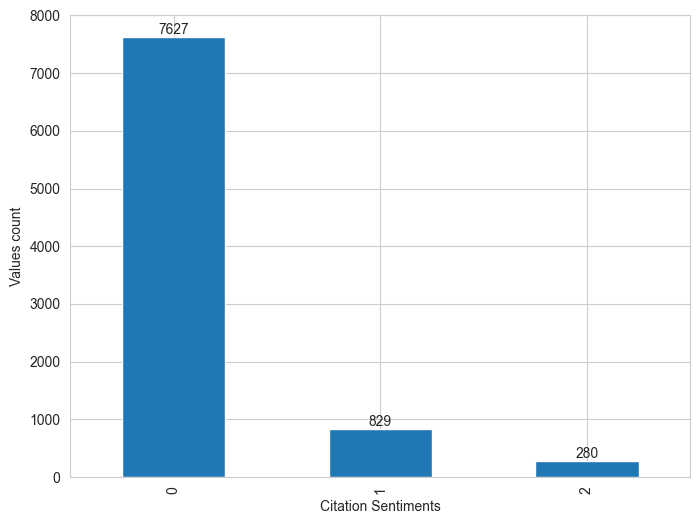

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,6))
rawdata_df.Sentiment.value_counts().plot(kind = 'bar',ax=ax)
for i, count in enumerate(rawdata_df.Sentiment.value_counts()):
    ax.text(i, count, str(count), ha='center', va='bottom')
plt.xlabel('Citation Sentiments')
plt.ylabel('Values count')
plt.show()

## 尝试欠采样和过采样

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# 分离特征和标签
X_text = rawdata_df['Citation_Text']
y = rawdata_df['Sentiment']

vectorizer = TfidfVectorizer(max_features=1000)
X_vectorized = vectorizer.fit_transform(X_text)

# 过采样策略：1500个正样本，1500个负样本，欠采样策略：3000个中性样本
over = SMOTE(sampling_strategy={1: 1500, 2: 1500}, k_neighbors=2, random_state=42)
under = RandomUnderSampler(sampling_strategy={0: 3000}, random_state=42)

# 应用过采样和欠采样
pipeline = Pipeline(steps=[('o', over), ('u', under)])
X_resampled, y_resampled = pipeline.fit_resample(X_vectorized, y)
X_resampled = vectorizer.inverse_transform(X_resampled)
X_resampled = [' '.join(words) for words in X_resampled]

resampled_df = pd.concat([pd.DataFrame(X_resampled, columns=['Citation_Text']), pd.DataFrame(y_resampled, columns=['Sentiment'])], axis=1)
resampled_df.head()


,Citation_Text,Sentiment
0,turney attention noun years 2008 problem one t...,0
1,marcus street treebank penn recall precision 9...,0
2,papineni reference variant find bleu score tra...,0
3,ney instead units och koehn common original wo...,0
4,ramshaw four marcus recognition representation...,0


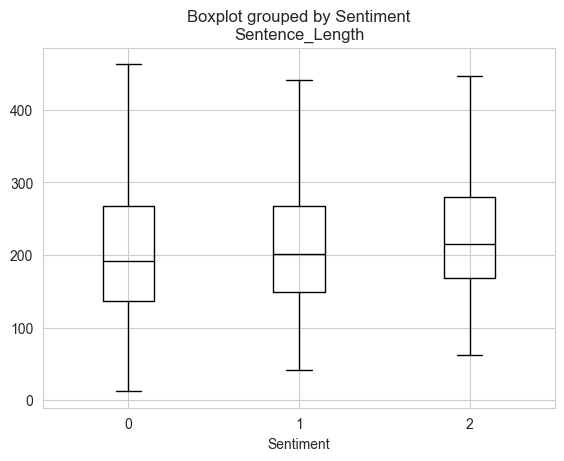

In [5]:
# 画出句子长度分布的箱型图
rawdata_df['Sentence_Length'] = rawdata_df['Citation_Text'].str.len()
rawdata_df.boxplot('Sentence_Length', by='Sentiment', showfliers=False, color='black')
plt.show()

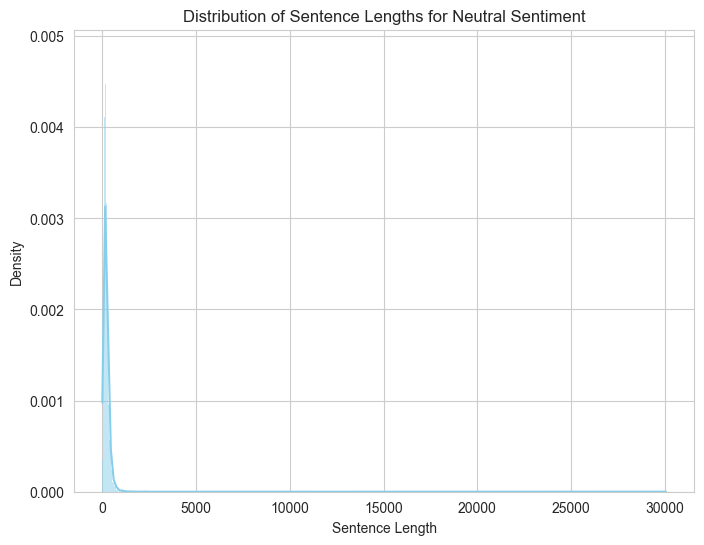

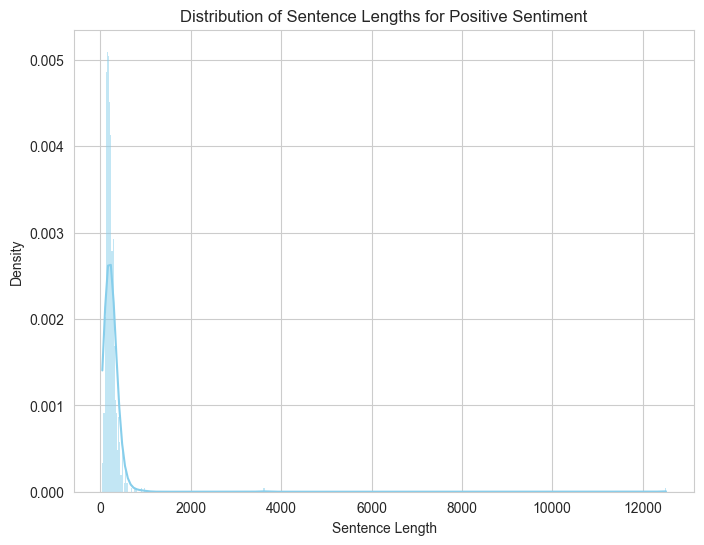

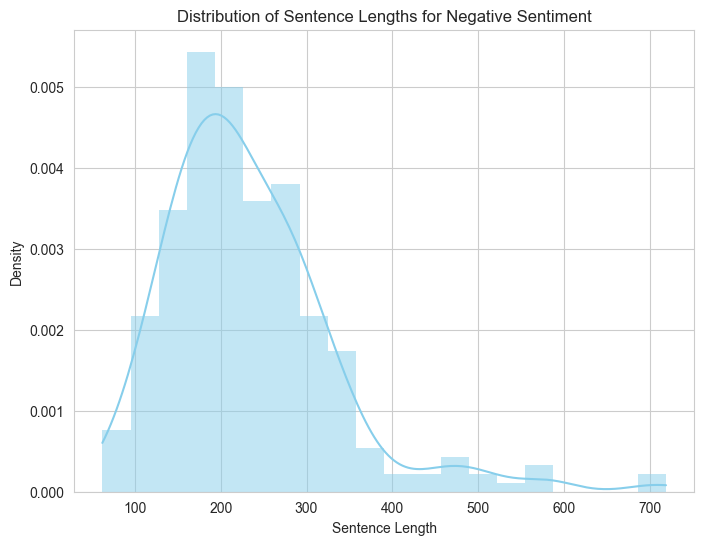

In [6]:
import seaborn as sns

labels = ['o', 'p', 'n']
label_names = ['Neutral', 'Positive', 'Negative']

for i, label in enumerate(labels):
    subset = rawdata_df[rawdata_df['Sentiment'] == label_map[label]]
    plt.figure(figsize=(8, 6))
    sns.histplot(subset['Sentence_Length'], kde=True, stat="density", linewidth=0, color='skyblue')
    plt.title(f'Distribution of Sentence Lengths for {label_names[i]} Sentiment')
    plt.xlabel('Sentence Length')
    plt.ylabel('Density')
    plt.show()

(8699, 5)


C:\Users\GaoFan\AppData\Local\Temp\ipykernel_49484\3759923245.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')
D:\User\anaconda3\envs\pytorch\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
D:\User\anaconda3\envs\pytorch\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


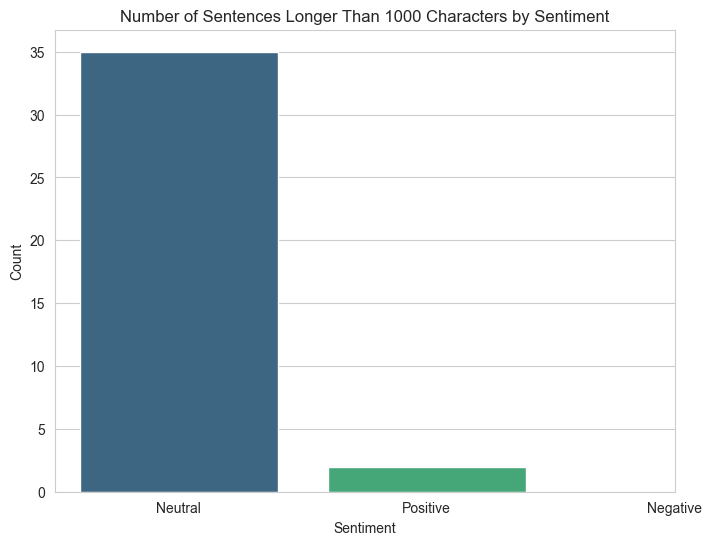

In [7]:
# Filter sentences longer than 1000 characters
long_sentences_df = rawdata_df[rawdata_df['Sentence_Length'] > 1000]
sentiment_counts = long_sentences_df.groupby('Sentiment').size()

rawdata_df = rawdata_df[rawdata_df['Sentence_Length'] <= 1000]
print(rawdata_df.shape)

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')
plt.title('Number of Sentences Longer Than 1000 Characters by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(ticks=range(len(label_map)), labels=['Neutral', 'Positive', 'Negative'])  # Assuming label_map is defined as in the context
plt.show()

## 使用Trainer类微调Citation的情感分析

In [10]:
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
from transformers import XLNetTokenizerFast, XLNetForSequenceClassification
from transformers import DataCollatorWithPadding
from datasets import Dataset, DatasetDict
import torch

# 分割数据集：训练集80%，验证集10%，测试集10%
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    rawdata_df['Citation_Text'].tolist(), rawdata_df['Sentiment'].tolist(), test_size=TEST_DATASET_SIZE, stratify=rawdata_df['Sentiment'], random_state=42)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42)

# 将数据转换为 HuggingFace 的 Dataset 格式
train_dataset = Dataset.from_dict({'text': train_texts, 'label': train_labels})
val_dataset = Dataset.from_dict({'text': val_texts, 'label': val_labels})
test_dataset = Dataset.from_dict({'text': test_texts, 'label': test_labels})
emotion_dataset = DatasetDict({'train': train_dataset, 'validation': val_dataset, 'test': test_dataset})

print(f"Train Dataset Size: {len(train_dataset)}")
print(f"Test Dataset Size: {len(test_dataset)}")
print(f"Val Dataset Size: {len(val_dataset)}")

Train Dataset Size: 5219
Test Dataset Size: 1740
Val Dataset Size: 1740


In [11]:
MODEL_NAME = 'distilbert-base-uncased'
MODEL_PATH = './model/distilbert-base-uncased'

# 分词器
tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_NAME)
# padding代表填充批量样本最长的长度 attention_mask代表哪些是padding的，此时模型就忽略输入的填充部分
tokenized_datasets = emotion_dataset.map(lambda f: tokenizer(f['text'], padding=True, truncation=True, return_tensors='pt', max_length=512),
                                      batch_size=16, batched=True) # WordPiece分词器
tokenized_datasets = tokenized_datasets.remove_columns(['text'])
# data_collator = DataCollatorWithPadding(tokenizer=tokenizer) # 在这加了datacollatorwithpadding就不用再tokenizer里加padding了
pd.DataFrame(tokenized_datasets['validation']).head()

Map:   0%|          | 0/5219 [00:00<?, ? examples/s]

Map:   0%|          | 0/1740 [00:00<?, ? examples/s]

Map:   0%|          | 0/1740 [00:00<?, ? examples/s]

,label,input_ids,attention_mask
0,0,"[101, 2057, 2179, 2008, 1996, 3972, 20624, 223...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,0,"[101, 2829, 3802, 2632, 1012, 2857, 1007, 1012...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, ..."
2,0,"[101, 1015, 4955, 17636, 2773, 12139, 2003, 20...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,1,"[101, 1999, 1996, 25835, 7655, 1011, 2241, 294...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,0,"[101, 2122, 3513, 2024, 4342, 2478, 1037, 2773...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


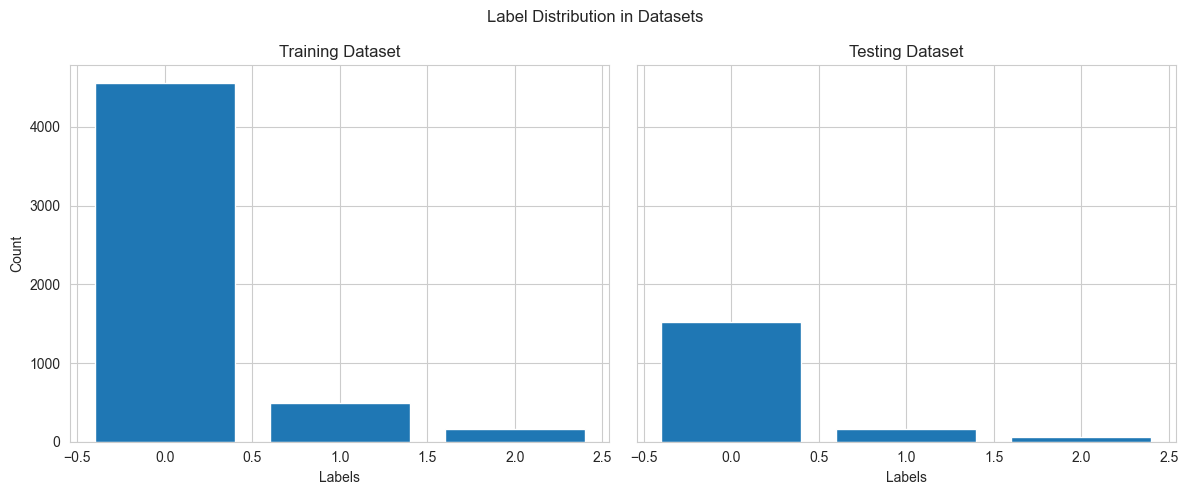

In [12]:
train_labels_count = {label: train_labels.count(label) for label in set(train_labels)}
test_labels_count = {label: test_labels.count(label) for label in set(test_labels)}

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
fig.suptitle('Label Distribution in Datasets')

# Training dataset plot
axes[0].bar(train_labels_count.keys(), train_labels_count.values())
axes[0].set_title('Training Dataset')
axes[0].set_xlabel('Labels')
axes[0].set_ylabel('Count')

# Testing dataset plot
axes[1].bar(test_labels_count.keys(), test_labels_count.values())
axes[1].set_title('Testing Dataset')
axes[1].set_xlabel('Labels')

plt.tight_layout()
plt.show()

## Dataloader加载数据集的微调，与用huggingface的datasets类加载数据集相同

In [13]:
from torch.utils.data import Dataset

class MyDataset(Dataset):
    '''
    重构数据集类，使其能够返回字典格式的数据，有标签
    '''
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


train_dataset = MyDataset(tokenizer(train_texts, truncation=True, padding=True, return_tensors='pt', max_length=512), train_labels)
test_dataset = MyDataset(tokenizer(test_texts, truncation=True, padding=True, return_tensors='pt', max_length=512), test_labels)
val_dataset = MyDataset(tokenizer(val_texts, truncation=True, padding=True, return_tensors='pt', max_length=512), val_labels)

print(f"Train Dataset Size: {len(train_dataset)}")
print(f"Test Dataset Size: {len(test_dataset)}")
print(f"Val Dataset Size: {len(val_dataset)}")

Train Dataset Size: 5219
Test Dataset Size: 1740
Val Dataset Size: 1740


In [14]:
import random

# 分词器测试
t = 'tokenizing text is a core task of NLP'
print(tokenizer(t, padding=True))
tokens = tokenizer.convert_ids_to_tokens(tokenizer(t)['input_ids'])
print(tokens)
print(tokenizer.convert_tokens_to_string(tokens))
print(tokenizer.vocab_size)

sample_text = train_texts[random.randint(0, len(train_texts))]
print("Sample Text:", sample_text)
encoded_input = tokenizer(sample_text, truncation=True, padding=True, return_tensors='pt', max_length=512)
print("Token IDs:", encoded_input['input_ids'])
decoded_text = tokenizer.decode(encoded_input['input_ids'][0], skip_special_tokens=True)
print("Decoded Text:", decoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '[SEP]']
[CLS] tokenizing text is a core task of nlp [SEP]
30522
Sample Text: This tolerant search uses the well known concept of Levenshtein distance in order to obtain the most similar string for the given prefix (see (Och et al., 2003) for more details).
Token IDs: tensor([[  101,  2023, 23691,  3945,  3594,  1996,  2092,  2124,  4145,  1997,
         23310,  6132, 11039, 12377,  3292,  1999,  2344,  2000,  6855,  1996,
          2087,  2714,  5164,  2005,  1996,  2445, 17576,  1006,  2156,  1006,
         28166,  3802,  2632,  1012,  1010,  2494,  1007,  2005,  2062,  4751,
          1007,  1012,   102]])
Decoded Text: this tolerant search uses the well known concept of levenshtein distance in order to obtain the most similar string for the given prefix ( se

In [15]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [16]:
from huggingface_hub import notebook_login
import wandb
import os

# notebook_login()

# 加载DistilBERT模型
id2label={0:"Neutral", 1:"Positive", 2:"Negative"}
label2id={"Neutral":0, "Positive":1, "Negative":2}
model = DistilBertForSequenceClassification.from_pretrained(MODEL_NAME, id2label=id2label, label2id=label2id, num_labels=NUM_LABELS, cache_dir=MODEL_PATH).to(device)
# model = DistilBertForSequenceClassification.from_pretrained(distilbert_model_sst2).to(device)
# model.classifier = torch.nn.Linear(model.classifier.in_features, 3) # 修改模型的分类头，使其适应三分类任务

# set the wandb project where this run will be logged
os.environ["WANDB_PROJECT"]="finetune-distilbert-sst2"

# save your trained model checkpoint to wandb
os.environ["WANDB_LOG_MODEL"]="true"

# turn off watch to log faster
os.environ["WANDB_WATCH"]="false"


# 定义训练参数
training_args = TrainingArguments(
    output_dir='./results',          # 输出结果目录
    report_to="wandb",
    num_train_epochs=3,
    learning_rate=5e-6,
    do_train=True,
    do_eval=True,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    weight_decay=0.1,
    warmup_steps=100,
    logging_strategy='steps',
    logging_dir='./logs',            # 日志目录
    logging_steps=50,
    eval_strategy="steps",
    eval_steps=50,
    disable_tqdm=False,
    save_strategy="steps",
    fp16= torch.cuda.is_available(), # faster and use less memory
    # metric_for_best_model='F1',
    load_best_model_at_end=True,
    # push_to_hub=True,
    label_smoothing_factor=0.1
)

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

D:\User\anaconda3\envs\pytorch\lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in E:\SeaFile - mails.tsinghu.edu.cn\同步盘\博二\数据要素\情感分析\citation-sentiment-analysis\model\distilbert-base-uncased\models--distilbert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
# 使用Focal loss作为损失函数解决样本不均衡问题
def py_sigmoid_focal_loss(pred, target, gamma=2.0, alpha=0.9, reduction='mean'):
    pred_sigmoid = pred.sigmoid()
    target = torch.nn.functional.one_hot(target, num_classes=pred.shape[1]).type_as(pred)  # 转换为one-hot编码
    pt = (1 - pred_sigmoid) * target + pred_sigmoid * (1 - target)
    focal_weight = (alpha * target + (1 - alpha) * (1 - target)) * pt.pow(gamma)
    loss = F.binary_cross_entropy_with_logits(pred, target, reduction='none') * focal_weight
    return loss.mean() if reduction == 'mean' else loss.sum()

class MultiFocalLoss(torch.nn.Module):
    """
    Focal_Loss= -1*alpha*((1-pt)**gamma)*log(pt)
    Args:
        num_class: number of classes
        alpha: class balance factor shape=[num_class, ]
        gamma: hyper-parameter
        reduction: reduction type
    """

    def __init__(self, num_class, alpha=None, gamma=2.0, reduction='mean'):
        super(MultiFocalLoss, self).__init__()
        self.num_class = num_class
        self.gamma = gamma
        self.reduction = reduction
        self.smooth = 1e-4
        self.alpha = alpha
        
        if alpha is None:
            self.alpha = torch.ones(num_class, ) - 0.5
        elif isinstance(alpha, (int, float)):
            self.alpha = torch.as_tensor([alpha] * num_class)
        elif isinstance(alpha, (list, np.ndarray)):
            self.alpha = torch.as_tensor(alpha)
        if self.alpha.shape[0] != num_class:
            raise RuntimeError('the length not equal to number of class')

    def forward(self, logit, target):
        # assert isinstance(self.alpha,torch.Tensor)\
        alpha = self.alpha.to(logit.device)
        prob = F.softmax(logit, dim=1)

        if prob.dim() > 2:
            # used for 3d-conv:  N,C,d1,d2 -> N,C,m (m=d1*d2*...)
            N, C = logit.shape[:2]
            prob = prob.view(N, C, -1)
            prob = prob.transpose(1, 2).contiguous()  # [N,C,d1*d2..] -> [N,d1*d2..,C]
            prob = prob.view(-1, prob.size(-1))  # [N,d1*d2..,C]-> [N*d1*d2..,C]

        ori_shp = target.shape
        target = target.view(-1, 1)

        prob = prob.gather(1, target).view(-1) + self.smooth  # avoid nan
        logpt = torch.log(prob)
        # alpha_class = alpha.gather(0, target.squeeze(-1))
        alpha_weight = alpha[target.squeeze().long()]
        loss = -alpha_weight * torch.pow(torch.sub(1.0, prob), self.gamma) * logpt

        if self.reduction == 'mean':
            loss = loss.mean()
        elif self.reduction == 'none':
            loss = loss.view(ori_shp)

        return loss

In [18]:
# DSELoss
class MultiDSCLoss(torch.nn.Module):
    r"""
    Creates a criterion that optimizes a multi-class Self-adjusting Dice Loss
    ("Dice Loss for Data-imbalanced NLP Tasks" paper)

    Args:
        alpha (float): a factor to push down the weight of easy examples
        gamma (float): a factor added to both the nominator and the denominator for smoothing purposes
        reduction (string): Specifies the reduction to apply to the output:
            ``'none'`` | ``'mean'`` | ``'sum'``. ``'none'``: no reduction will be applied,
            ``'mean'``: the sum of the output will be divided by the number of
            elements in the output, ``'sum'``: the output will be summed.

    Shape:
        - logits: `(N, C)` where `N` is the batch size and `C` is the number of classes.
        - targets: `(N)` where each value is in [0, C - 1]
    """

    def __init__(self, alpha=1.0, smooth=1.0, reduction="mean"):
        super(MultiDSCLoss, self).__init__()
        self.alpha = alpha
        self.smooth = smooth
        self.reduction = reduction

    def forward(self, logits, targets):
        probs = torch.softmax(logits, dim=1)
        probs = torch.gather(probs, dim=1, index=targets.unsqueeze(1))

        probs_with_factor = ((1 - probs) ** self.alpha) * probs
        loss = 1 - (2 * probs_with_factor + self.smooth) / (probs_with_factor + 1 + self.smooth)

        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        elif self.reduction == "none" or self.reduction is None:
            return loss
        else:
            raise NotImplementedError(f"Reduction `{self.reduction}` is not supported.")

In [19]:
import torch
import torch.nn.functional as F

 
class CustomTrainer(Trainer):
    def __init__(self, loss_type='focal_loss', *args, **kwargs):
        super(CustomTrainer, self).__init__(*args, **kwargs)
        self.loss_type = loss_type

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        if self.loss_type == 'focal_loss':
            loss_fct = MultiFocalLoss(num_class=3, alpha=0.8, gamma=2.0)
        elif self.loss_type == 'dsc_loss':
            loss_fct = MultiDSCLoss(alpha=1.0, smooth=1.0)
        elif self.loss_type == 'ce_loss':
            loss_fct = torch.nn.CrossEntropyLoss()
        else:
            loss_fct = torch.nn.CrossEntropyLoss()
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [20]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
 
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

# 创建Trainer
trainer = CustomTrainer(
    model=model,
    args=training_args,
    # train_dataset=train_dataset,
    # eval_dataset=val_dataset,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    tokenizer=tokenizer,
    # data_collator=data_collator,
    compute_metrics=compute_metrics,
    loss_type='dsc_loss' # 自定义参数 focal_loss dsc_loss
)

In [21]:
results = trainer.train() 
wandb.finish()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: gaof23 (gaof23-tsinghua-university). Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,0.342700,0.338940,0.872414,0.310620,0.290805,0.333333
100,0.338400,0.337402,0.872414,0.310620,0.290805,0.333333
150,0.336800,0.336859,0.872414,0.310620,0.290805,0.333333
200,0.337600,0.336787,0.872414,0.310620,0.290805,0.333333
250,0.337200,0.336797,0.872414,0.310620,0.290805,0.333333
300,0.336300,0.336675,0.872414,0.310620,0.290805,0.333333
350,0.337000,0.336600,0.872414,0.310620,0.290805,0.333333
400,0.335700,0.336563,0.872414,0.314574,0.457614,0.335122
450,0.335900,0.336493,0.872414,0.314574,0.457614,0.335122
500,0.336500,0.336416,0.872989,0.318591,0.513337,0.337130


D:\User\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\User\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\User\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\User\anaconda3\envs\pytorch\lib\si

eval/Accuracy,▁▁▁▁▁▁▁▁▁▁▁▅█▄▇▇▇██
eval/F1,▁▁▁▁▁▁▁▁▁▁▂▄▅█▅▆▅▇▇
eval/Precision,▁▁▁▁▁▁▁▅▅▇▆▇█▆▇▇█▆▆
eval/Recall,▁▁▁▁▁▁▁▁▁▁▂▃▄█▅▅▄▇▆
eval/loss,█▄▃▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁
eval/runtime,▄▂▂▁▂▄▁▂▃▂▄▃▁▃▂▁▅▃█
eval/samples_per_second,▅▇▇█▇▅█▇▅▇▅▆█▅▇█▄▅▁
eval/steps_per_second,▅▇▇█▇▅█▇▅▇▅▆█▅▇█▄▅▁
train/epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train/grad_norm,█▃▃▃▇▄▁▁▂▃▄▄▃▂▃▂▂▅▁


In [22]:
# q=[trainer.evaluate(eval_dataset = data) for data in [train_dataset, val_dataset, test_dataset]]
# pd.DataFrame(q, index=["train","val","test"]).iloc[:,:5]

## 评估模型:ROC曲线

accuracy、precision(预测为1/真实为1)、recall(真实为1/预测为1)和F1-score

F1-score = 2 * (precision * recall) / (precision + recall)

Micro-F1: 将所有类别的TP、FP、FN分别累加，然后计算F1-score

Macro-F1: 分别计算每个类别的F1-score，然后求平均

C:\Users\GaoFan\AppData\Local\Temp\ipykernel_49484\386509396.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


D:\User\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


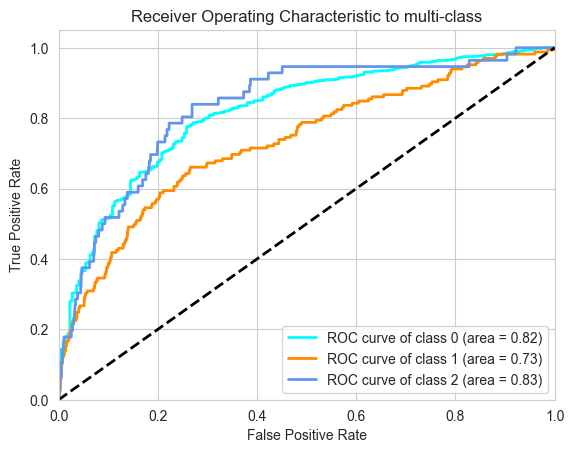

In [23]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
import numpy as np

predictions = trainer.predict(test_dataset)
probs = torch.softmax(torch.tensor(predictions.predictions), dim=-1).numpy()

def plot_roc_curve(labels, probs):
    # 计算ROC曲线
    fpr = {}
    tpr = {}
    roc_auc = {}
    
    # 将标签转换为One-hot编码
    test_labels_one_hot = np.eye(3)[labels]
    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(test_labels_one_hot[:, i], probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # 绘制ROC曲线
    plt.figure()
    colors = ['aqua', 'darkorange', 'cornflowerblue']
    for i, color in zip(range(3), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (area = {1:0.2f})'
                                                           ''.format(i, roc_auc[i]))
        
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()

plot_roc_curve(test_labels, probs)

## PR曲线

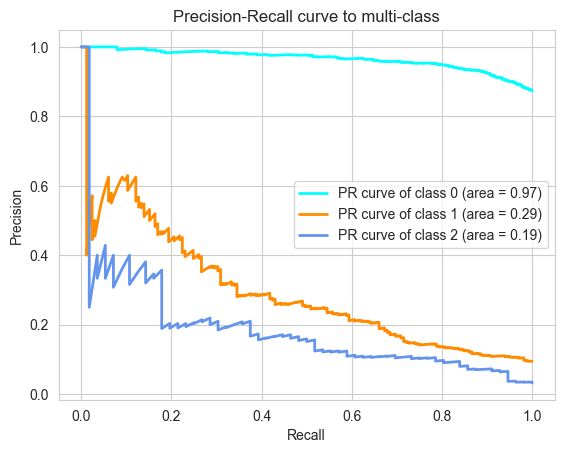

In [24]:
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_pr_curve(labels, probs):
    
    precision = {}
    recall = {}
    average_precision = {}
    test_labels_one_hot = np.eye(3)[labels]
    
    for i in range(3):
        precision[i], recall[i], _ = precision_recall_curve(test_labels_one_hot[:, i], probs[:, i])
        average_precision[i] = average_precision_score(test_labels_one_hot[:, i], probs[:, i])

    plt.figure()
    colors = ['aqua', 'darkorange', 'cornflowerblue']
    for i, color in zip(range(3), colors):
        plt.plot(recall[i], precision[i], color=color, lw=2, label='PR curve of class {0} (area = {1:0.2f})'
                                                           ''.format(i, average_precision[i]))

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve to multi-class')
    plt.legend(loc="best")
    plt.show()

plot_pr_curve(test_labels, probs)

## 混淆矩阵

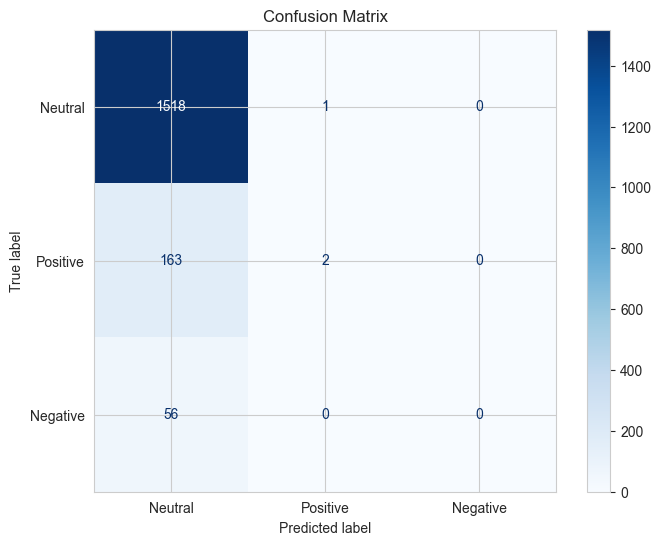

In [25]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', values_format='d', ax=ax)
    plt.title('Confusion Matrix')
    plt.show()
    
predicted_labels = np.argmax(predictions.predictions, axis=1)
plot_confusion_matrix(test_labels, predicted_labels, list(label2id.keys()))

## 使用原生Pytorch训练

In [26]:
# https://zhuanlan.zhihu.com/p/662578119 还没写,感觉微调就可以达到效果
# pytorch实现训练

# from torch.utils.data import DataLoader
# from transformers import AdamW
# 
# train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)
# 
# optimizer = AdamW(model.parameters(), lr=1e-3)

## 画出情感得分的时序数据图

In [27]:
from torch.utils.data import DataLoader, ConcatDataset

best_model_dir = './model/distilbert-base-uncased-finetuned-citation'
trainer.save_model(best_model_dir)
best_model = DistilBertForSequenceClassification.from_pretrained(best_model_dir).to(device)

def predict_sentiment_score(model, dataset, batched=True, batch_size=32, weights=[-0.5, 1, -1], shuffle=False):
    '''
    预测句子的情感
    '''
    results = []
    sentiment_scores = []
    model.eval()  # 将模型设置为评估模式

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

    if batched:
        with torch.no_grad():  # 不计算梯度，以加速和节省内存
            for batch in dataloader:
                # 将批次数据移动到cuda
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs = model(**batch)
                logits = outputs.logits
                probabilities = F.softmax(logits, dim=-1)
                
                logits_list = logits.tolist()
                probabilities_list = probabilities.tolist()
                results.extend(zip(logits_list, probabilities_list))
    else:
        with torch.no_grad():
            inputs = tokenizer(dataset, return_tensors='pt', truncation=True, padding=True).to(device)
            outputs = model(**inputs)
            logits = outputs.logits
            probabilities = F.softmax(logits, dim=-1)
            logits_list = logits.tolist()
            probabilities_list = probabilities.tolist()
            results.extend(zip(logits_list, probabilities_list))

    for _, softmax_probs in results:
        softmax_probs_array = np.array(softmax_probs)
        weights_array = np.array(weights)
        score = np.sum(softmax_probs_array * weights_array)
        score = max(min(score, 1), -1)
        sentiment_scores.append(score)
    return sentiment_scores

weights=[-0.1, 1, -1]
all_dataset = ConcatDataset([train_dataset, test_dataset, val_dataset])
sentiment_scores = predict_sentiment_score(best_model, all_dataset, weights=weights, batched=True, batch_size=1, shuffle=True) # 句子维度不一样就把batch_size设为1


C:\Users\GaoFan\AppData\Local\Temp\ipykernel_49484\386509396.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


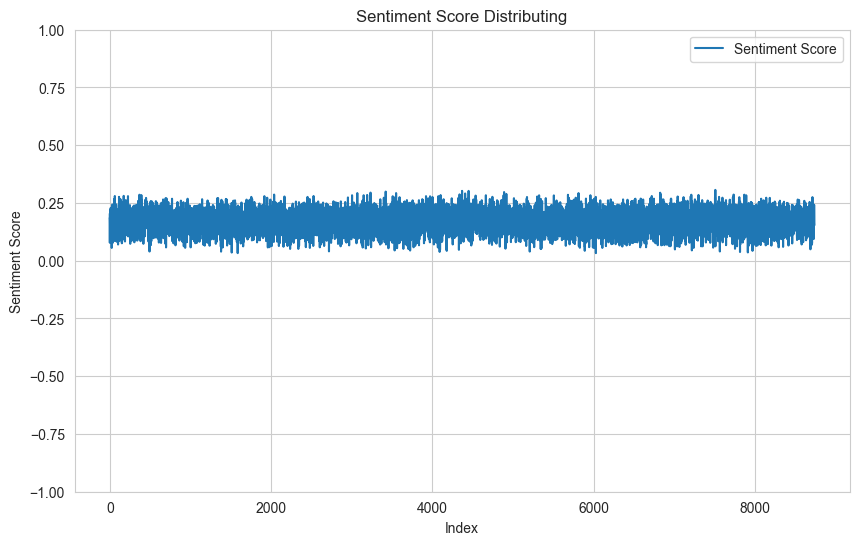

In [33]:

# # Pipeline的方法只能输出概率最大的标签和对应的标签值
# # 因此他的值不可能小于0.3333，要输出连续的得分值在-1到1之间，需要自己利用logits或者概率值实现
best_model_pipeline = pipeline(task='sentiment-analysis', model=best_model_dir, tokenizer=tokenizer, device='cuda')
sst2_model_pipeline = pipeline(task='sentiment-analysis', model=distilbert_model_sst2, tokenizer=tokenizer, device='cuda')

# # Function to truncate sequences
# def truncate_sequences(texts, max_length=512):
#     return [tokenizer.decode(tokenizer.encode(text, max_length=max_length, truncation=True), skip_special_tokens=True) for text in texts]

# # Apply truncation
# mydata = truncate_sequences(rawdata_df['Citation_Text'].tolist())
# predictions = best_model_pipeline(mydata)
# scores = [prediction['score'] for prediction in predictions]
time_series_df = pd.DataFrame({'Sentiment Score': sentiment_scores}, index=rawdata_df.index)

plt.figure(figsize=(10, 6))
plt.plot(time_series_df.index, time_series_df['Sentiment Score'], label='Sentiment Score')
plt.xlabel('Index')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Score Distributing')
plt.ylim(-1, 1)
# plt.axhline(y=0, color='r', linestyle='--')
plt.legend()
plt.show()

## 对自己构造的数据集进行情感分析并画出时序图

(97, 2)


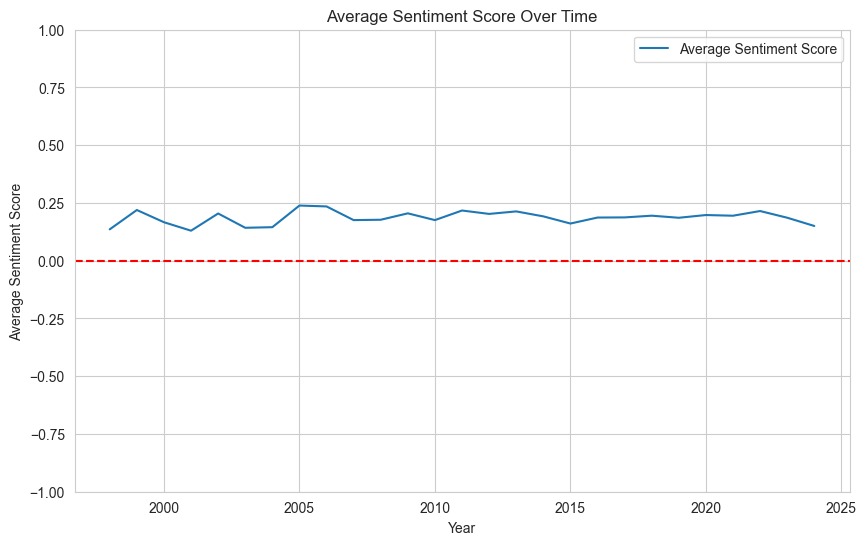

In [34]:
new_df = pd.read_csv('./data/citation_manual_cleaned.csv')
print(new_df.shape)

texts = list(map(lambda x: x.lower(), new_df['texts']))
year = list(map(lambda x: int(x), new_df['year']))

scores = predict_sentiment_score(best_model, texts, weights=weights, batched=False) # 句子维度不一样就把batch_size设为1

time_series_df = pd.DataFrame({'Year': year, 'Sentiment Score': scores})
yearly_scores = time_series_df.groupby('Year')['Sentiment Score'].mean().reset_index()
time_series_df.to_csv('./data/sentiment_scores.csv', index=False)

plt.figure(figsize=(10, 6))
plt.plot(yearly_scores['Year'], yearly_scores['Sentiment Score'], label='Average Sentiment Score')
plt.xlabel('Year')
plt.ylabel('Average Sentiment Score')
plt.title('Average Sentiment Score Over Time')
plt.ylim(-1, 1)
plt.axhline(y=0, color='r', linestyle='--')
plt.legend()
plt.show()

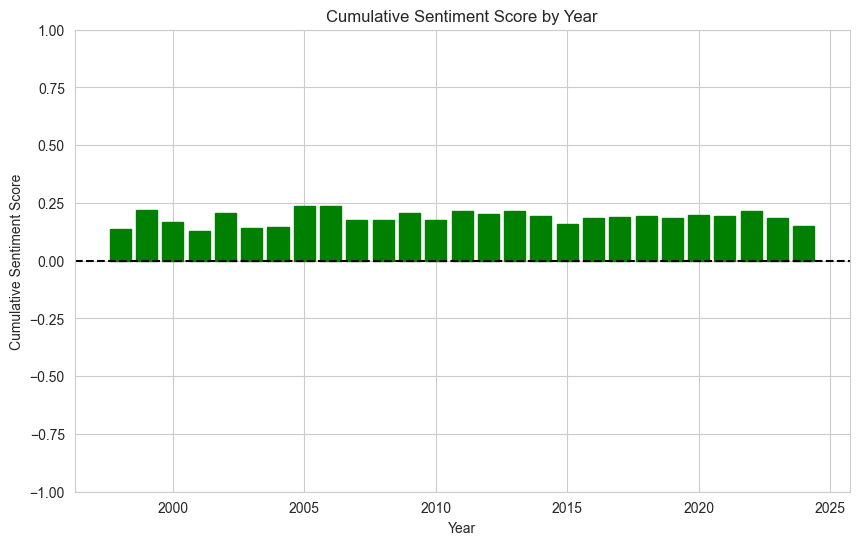

In [35]:
plt.figure(figsize=(10, 6))
bars = plt.bar(yearly_scores['Year'], yearly_scores['Sentiment Score'], bottom=0)

# Color bars based on their extension direction
for bar in bars:
    if bar.get_height() > 0:
        bar.set_color('green')  # Extend upwards
    else:
        bar.set_color('red')    # Extend downwards

plt.xlabel('Year')
plt.ylabel('Cumulative Sentiment Score')
plt.title('Cumulative Sentiment Score by Year')
plt.ylim(-1, 1)  # Ensure y-axis ranges from 0 to 1
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

## 通过文献的Related Work进行正向的情感分析

In [36]:
related_works_df = pd.read_excel('./data/related_works.xlsx')
paragraphs = list(map(lambda x: x.lower(), related_works_df['related work']))
paragraphs

['stochastic geometry is a mathematical tool that characterizes the spatial distributions of base stations’ and users’ locations in wireless networks [3]–[5]. significant progress has been made in recent years on characterizing wireless networks’ coverage and rate performances using stochastic geometry. by modeling the placements of base stations and users according to poisson point processes (ppps), analytically tractable ex- pressions for coverage and rates, which produce useful insights on network design guidance, have been found for ad-hoc [4]– [8], cellular [9]–[11], multi-antenna [12]–[15], mmwave [16]– [19], and uavs [20], [21] networks. continuing in the same spirit, in this work, we develop a tractable model for satellite downlink networks and characterize the coverage probability to illuminate the design principle of satellite downlink net- works in terms of relevant network parameters. satellite network models based on stochastic geometry are recently obtaining momentum comp

In [37]:
import re

all_sentences = []
for idx, paragraph in enumerate(paragraphs):
    """
    Splits text into sentences based on sentence-ending punctuation.
    """
    sentences = re.split(r'(?<=[.!?]) +', paragraph) # 正则表达式分段
    for i, sentence in enumerate(sentences):
        all_sentences.append({'paragraph_index': idx, 'sentence_index': i, 'sentence': sentence})

df_sentences = pd.DataFrame(all_sentences)
df_sentences.head()

,paragraph_index,sentence_index,sentence
0,0,0,stochastic geometry is a mathematical tool tha...
1,0,1,significant progress has been made in recent y...
2,0,2,by modeling the placements of base stations an...
3,0,3,"continuing in the same spirit, in this work, w..."
4,0,4,satellite network models based on stochastic g...


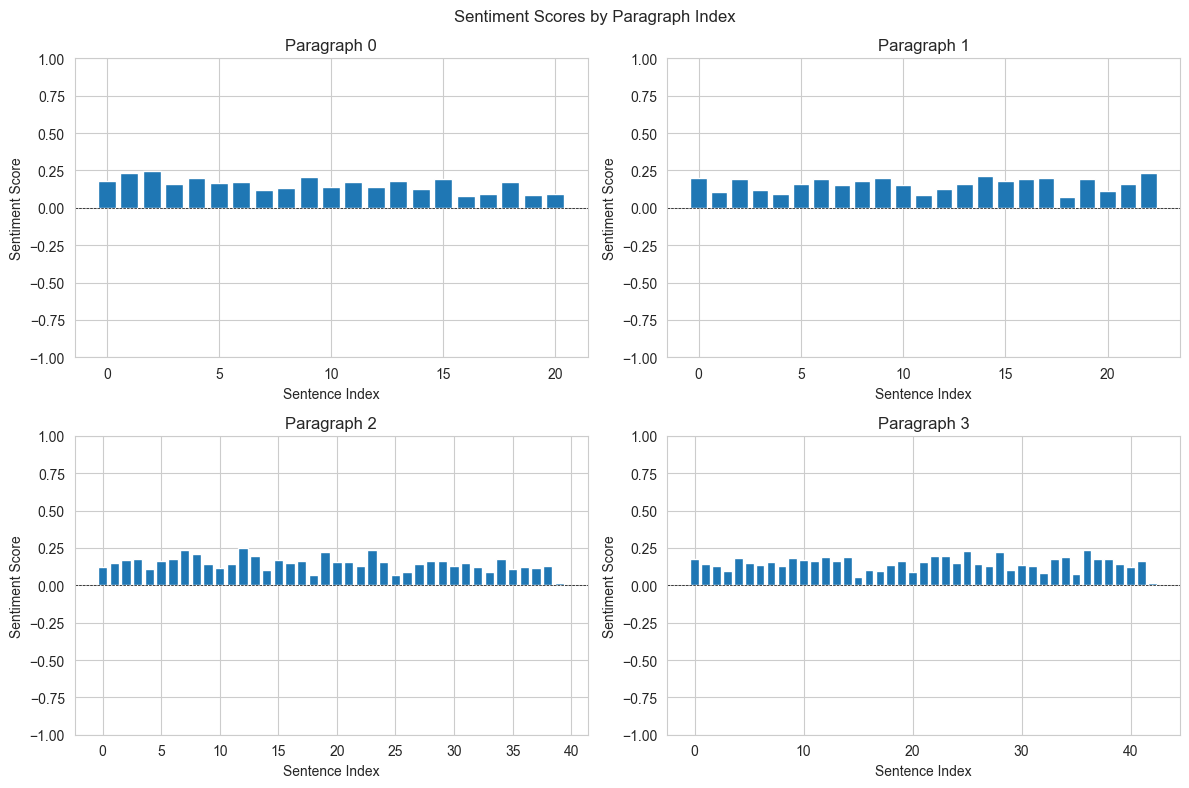

In [38]:
paragraph_scores = {0: [], 1: [], 2: [], 3: []}

for idx in range(4):
    sentences = df_sentences[df_sentences['paragraph_index'] == idx]['sentence'].tolist()
    scores = predict_sentiment_score(best_model, sentences, weights=weights, batched=False) # 句子维度不一样就把batch_size设为1
    paragraph_scores[idx] = scores

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Sentiment Scores by Paragraph Index')

# Color bars based on their extension direction
for bar in bars:
    if bar.get_height() > 0:
        bar.set_color('green')  # Extend upwards
    else:
        bar.set_color('red')    # Extend downwards
for idx, ax in enumerate(axs.flat):
    # ax.plot(paragraph_scores[idx], label=f'Paragraph {idx}')
    scores = np.array(paragraph_scores[idx])
    bars = ax.bar(range(len(scores)), abs(scores), bottom=0.0)
    ax.set_title(f'Paragraph {idx}')
    ax.set_xlabel('Sentence Index')
    ax.set_ylabel('Sentiment Score')
    ax.set_ylim(-1, 1)  # Ensure y-axis ranges from 0 to 1
    ax.axhline(y=0, color='black', linestyle='--',linewidth=0.5)
    # ax.legend()

plt.tight_layout()
plt.show()

In [39]:
citation_df = pd.read_excel('./data/citation_manual_new.xlsx')
print(citation_df.shape)
citation_df.iloc[:, [1, 3, 5, 7]] = citation_df.iloc[:, [1, 3, 5, 7]].astype(int)
citation_df.head()

(27, 20)


,A simple and efficient search algorithm for block-matching motion estimation,year,M-PSK and M-QAM BER computation using signal-space concepts,year.1,Companding transform for reduction in peak-to-average power ratio of OFDM signals,year.2,A planar monopole antenna design with band-notched characteristic,year.3,Bit-interleaved time-frequency coded modulation for OFDM systems over time-varying channels,year.4,Robust video transmission over correlated mobile fading channels,year.5,A time-frequency decision-feedback loop for carrier frequency offset tracking in OFDM systems,year.6,Nonpilot-aided carrier frequency tracking for uplink OFDMA systems,year.7,A receive space diversity architecture for OFDM systems using orthogonal designs,year.8,Carrier Frequency Offset Estimation Using Extended Kalman Filter in Uplink OFDMA Systems,year.9
0,"As a result, BMA develop a set of solutions fo...",2024,"For Gray-mapped Mn-PSK modulation, the BER ove...",2024,They found that the linear nonsymmetrical tran...,2024,NaN,2024,NaN,2024,NaN,2024,NaN,2024,NaN,2024,NaN,2024,NaN,2024
1,"many fast algorithms have been proposed, such ...",2023,"We will follow the approach, proposed in [23],...",2023,Several PAPR reducion techniques have been pro...,2023,"Meanwhile, various structural design methods h...",2023,NaN,2023,NaN,2023,NaN,2023,NaN,2023,Inspired by the concept of spatial diversity e...,2023,NaN,2023
2,"To improve the speed of motion estimation, sev...",2022,The conditional bit error rate (BER) of user ...,2022,To compare the transform-based companding tech...,2022,"In general, the notched bands can be realized ...",2022,Fig. 13 shows the comparison between the propo...,2022,NaN,2022,NaN,2022,NaN,2022,Inspired by the concept of spatial diversity e...,2022,NaN,2022
3,The Simple and Efficient Search (SES) algorith...,2021,To evaluate the maximum available transmission...,2021,The use of a compander was explored in OFDM s...,2021,A monopole antenna with a C-shape slot on a pa...,2021,The optimal maximum likelihood (ML) bit metric...,2021,NaN,2021,NaN,2021,"in Reference [11], it develops a tracking sche...",2021,NaN,2021,NaN,2021
4,Table 2 Critical inferencing overview of frequ...,2020,"For phase-shift keying modulation, we can refe...",2020,Other related approaches such as peak windowin...,2020,NaN,2020,NaN,2020,NaN,2020,NaN,2020,NaN,2020,NaN,2020,NaN,2020


In [40]:
# 处理NaN值并进行情感分析
def analyze_sentiment(text):
    if pd.isna(text):
        return 0  # 对于NaN文本，情感得分设置为0
    scores = predict_sentiment_score(best_model, text, weights=weights, batched=False) # 句子维度不一样就把batch_size设为1
    return scores[0]

text_columns = citation_df.columns[::2]
citation_df_with_scores = citation_df

for i, col in enumerate(text_columns):
    sentiment_scores = citation_df_with_scores[col].apply(analyze_sentiment)
    new_col_name = f"Sentiment_Score{i}"
    citation_df_with_scores.insert(2*i+i+1, new_col_name, sentiment_scores)

citation_df_with_scores.to_csv('./data/citation_with_sentiment_scores.csv', index=False)
citation_df_with_scores.head()

,A simple and efficient search algorithm for block-matching motion estimation,Sentiment_Score0,year,M-PSK and M-QAM BER computation using signal-space concepts,Sentiment_Score1,year.1,Companding transform for reduction in peak-to-average power ratio of OFDM signals,Sentiment_Score2,year.2,A planar monopole antenna design with band-notched characteristic,...,year.6,Nonpilot-aided carrier frequency tracking for uplink OFDMA systems,Sentiment_Score7,year.7,A receive space diversity architecture for OFDM systems using orthogonal designs,Sentiment_Score8,year.8,Carrier Frequency Offset Estimation Using Extended Kalman Filter in Uplink OFDMA Systems,Sentiment_Score9,year.9
0,"As a result, BMA develop a set of solutions fo...",0.122394,2024,"For Gray-mapped Mn-PSK modulation, the BER ove...",0.152796,2024,They found that the linear nonsymmetrical tran...,0.188072,2024,NaN,...,2024,NaN,0.000000,2024,NaN,0.000000,2024,NaN,0.0,2024
1,"many fast algorithms have been proposed, such ...",0.248876,2023,"We will follow the approach, proposed in [23],...",0.153007,2023,Several PAPR reducion techniques have been pro...,0.197249,2023,"Meanwhile, various structural design methods h...",...,2023,NaN,0.000000,2023,Inspired by the concept of spatial diversity e...,0.180127,2023,NaN,0.0,2023
2,"To improve the speed of motion estimation, sev...",0.257279,2022,The conditional bit error rate (BER) of user ...,0.187052,2022,To compare the transform-based companding tech...,0.173566,2022,"In general, the notched bands can be realized ...",...,2022,NaN,0.000000,2022,Inspired by the concept of spatial diversity e...,0.180127,2022,NaN,0.0,2022
3,The Simple and Efficient Search (SES) algorith...,0.225298,2021,To evaluate the maximum available transmission...,0.186215,2021,The use of a compander was explored in OFDM s...,0.180917,2021,A monopole antenna with a C-shape slot on a pa...,...,2021,"in Reference [11], it develops a tracking sche...",0.109579,2021,NaN,0.000000,2021,NaN,0.0,2021
4,Table 2 Critical inferencing overview of frequ...,0.184071,2020,"For phase-shift keying modulation, we can refe...",0.141618,2020,Other related approaches such as peak windowin...,0.208637,2020,NaN,...,2020,NaN,0.000000,2020,NaN,0.000000,2020,NaN,0.0,2020


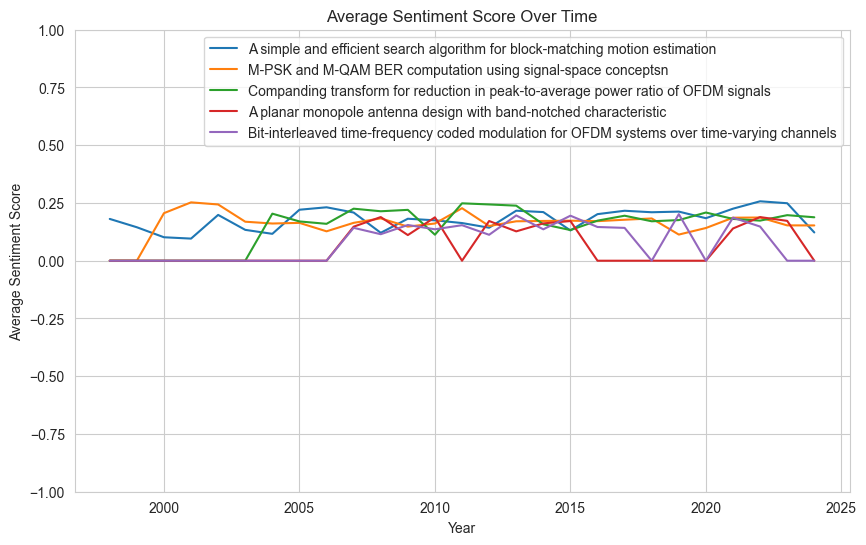

In [41]:
plt.figure(figsize=(10, 6))
plt.plot(citation_df_with_scores['year'], citation_df_with_scores['Sentiment_Score0'], label='A simple and efficient search algorithm for block-matching motion estimation')
plt.plot(citation_df_with_scores['year'], citation_df_with_scores['Sentiment_Score1'], label='M-PSK and M-QAM BER computation using signal-space conceptsn')
plt.plot(citation_df_with_scores['year'], citation_df_with_scores['Sentiment_Score2'], label='Companding transform for reduction in peak-to-average power ratio of OFDM signals')
plt.plot(citation_df_with_scores['year'], citation_df_with_scores['Sentiment_Score3'], label='A planar monopole antenna design with band-notched characteristic')
plt.plot(citation_df_with_scores['year'], citation_df_with_scores['Sentiment_Score4'], label='Bit-interleaved time-frequency coded modulation for OFDM systems over time-varying channels')
plt.xlabel('Year')
plt.ylabel('Average Sentiment Score')
plt.title('Average Sentiment Score Over Time')
plt.ylim(-1, 1)
plt.legend()
plt.show()